In [6]:
import xarray as xr
import iris
import netCDF4 as nc4
import os
from functools import reduce
import matplotlib.pyplot as plt
import pandas as pd
from calendar import month_abbr
from IPython.display import Image
import seaborn as sns
from scipy import stats
import _pickle as cpickle
import matplotlib as mpl
mpl.style.use("ggplot")
from cdo import Cdo
from collections import OrderedDict
from statsmodels.distributions.empirical_distribution import ECDF
import sys
from cftime import Datetime360Day

<ol>
    <p>Features to implement:</p>
    <li>Automatic renaming of time, lon, lat dimensions to a default name for consistency</li>
    <li>Automatic reordering to (time, lon, lat)</li>
    <li></li>
    <li></li>
</ol>

<font color="red">WARNING!</font> Setting the cftimeindex option to <font color='green'>True</font> ==> Losing out on some features?
This enable better handling of 360-day timesteps

In [7]:
xr.set_options(enable_cftimeindex=True)

### Loading the pickled data

In [8]:
for obj in ['precip', 'precip_monclim', 'clim', 'precip_new', 'allthresh_climdf']:
    with open(f"../../output/pickled_objects/analysis1/{obj}.pickle", "rb") as loadFile:
        globals()[obj] = cpickle.load(loadFile)

### Loading in the datasets

#### Define a function to get the directory structure

In [9]:
def get_directory_structure(rootdir):
    """
    Creates a nested dictionary that represents the folder structure of rootdir
    """
    dir_dict = {}
    rootdir = rootdir.rstrip(os.sep)
    start = rootdir.rfind(os.sep) + 1
    for path, dirs, files in os.walk(rootdir):
        folders = path[start:].split(os.sep)
        subdir = dict.fromkeys(files)
        parent = reduce(dict.get, folders[:-1], dir_dict)
        parent[folders[-1]] = subdir
    return dir_dict

#### Bias corrected precipitation data for various methods loaded in as xarray datasets

In [67]:
precip = get_directory_structure('/home/abhi/Documents/mygit/BC/output/precip/mw30-15/base/')['base']
precip = {'mw30-15': precip}

In [69]:
threshlist = [0, 0.01, 0.2]
os.chdir('/home/abhi/Documents/mygit/BC/output/precip/mw30-15/base/')
for thresh in np.array(threshlist, dtype=str):
    select_dict = precip[method][thresh]
    for BCtype in select_dict.keys():
        target_file = f'{thresh}/{BCtype}'
        select_dict[BCtype] = xr.open_dataset(target_file)

        if ('t' in select_dict[BCtype].coords and 
            'time' not in select_dict[BCtype].coords):

            mod[BCtype] = mod[BCtype].rename({'t': 'time'})

            for olddim, newdim in {'longitude':'lon', 'latitude': 'lat'}.items():
                try:
                    mod = mod[BCtype].rename({olddim: newdim})
                except ValueError:
                    pass
                
            
os.chdir("/home/abhi/Documents/mygit/postBC_diagnostic/src/notebooks")

/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'precip' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'precip' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'precip' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'precip' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'precip' has mul

#### Pickle precip dictionary

In [186]:
with open("../../output/pickled_objects/analysis1/precip.pickle", "wb") as writeFile:
    cpickle.dump(precip, writeFile)

### Monthly mean climatologies comparison (ALL INDIA averages)

#### For each method, and threshold calculate the monthly mean climatologies

In [70]:
precip_monclim = {}

In [71]:
%%time
for method in ['mw30-15']:
    precip_monclim[method] = {}
    for thresh in np.array([0, 0.01, 0.2], dtype=str):

        precip_monclim[method][thresh] = pd.DataFrame({'thresh': np.full(12, thresh)},
                                                      index=np.arange(1, 13, 1))
        precip_monclim[method][thresh]['method'] = np.full(12, method)

        select_dict = precip[method][thresh]
        for BCtype in select_dict.keys():
            select = select_dict[BCtype].precip
            reduced = select.groupby('time.month').mean('time').mean(['lat', 'lon'])
            precip_monclim[method][thresh][BCtype] = reduced.to_dataframe(name=BCtype)

        precip_monclim[method][thresh] = precip_monclim[method][thresh][['delta',
                                 'scaling-additive',
                                 'scaling-multiplicative',
                                 'loci',
                                 'eqm',
                                 'gamma', 'thresh', 'method']
                               ]

/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CPU times: user 1min 51s, sys: 26.9 s, total: 2min 18s
Wall time: 6min 4s


#### Pickle precip_monclim dictionary

In [190]:
with open("../../output/pickled_objects/analysis1/precip_monclim.pickle", "wb") as writeFile:
    cpickle.dump(precip_monclim, writeFile)

#### Combined DataFrame for method and threshold

In [10]:
df_concat = pd.concat(objs=(precip_monclim['mw30-15']['0'],
                            precip_monclim['mw30-15']['0.01'],
                            precip_monclim['mw30-15']['0.2'])
                     , axis=0)

df_concat.index.name = 'month'
df_concat['month'] = df_concat.index
df_concat.set_index(['method', 'thresh', 'month'], inplace=True)
df_concat.head()

delta  scaling-additive  scaling-multiplicative  \
method  thresh month                                                       
mw30-15 0      1      0.571180          0.581443                0.589720   
               2      0.864407          0.851964                0.858930   
               3      1.036394          1.068779                1.067545   
               4      1.348647          1.331602                1.318693   
               5      2.106731          2.274339                2.148403   

                          loci       eqm     gamma  
method  thresh month                                
mw30-15 0      1      0.685907  0.585653  0.608853  
               2      0.906107  0.873953  0.913499  
               3      0.971951  1.083907  1.154605  
               4      1.204296  1.356188  1.459150  
               5      1.528746  2.223076  2.625032

#### Make a separate DataFrame for IMD observation data and PRECIS original (non bias corrected data)

In [11]:
def homo_dims(xr_ds):
    '''A convention for consistent dimension names'''
    if 't' in xr_ds.coords and 'time' not in xr_ds.coords:
        xr_ds = xr_ds.rename({'t': 'time'})
    
    for olddim, newdim in {'longitude': 'lon', 'latitude': 'lat'}.items():
        try:
            xr_ds = xr_ds.rename({olddim: newdim})
        except ValueError:
            pass
        
    return xr_ds

In [12]:
data_dir = '/home/abhi/Documents/data'

obs = homo_dims(xr.open_dataset(os.path.join(data_dir, 'OBSERVATION/IMD/precip/imdCAL.nc')))
mod = homo_dims(xr.open_dataset(os.path.join(data_dir, 'PRECIS/base/precip/1971-2000_rm_ll25.nc')))


In [ ]:
clim = {}

clim['obs'] = obs.groupby('time.month').mean('time').mean(['lat', 'lon']).precip.values
clim['mod'] = mod.groupby('time.month').mean('time').mean(['lat', 'lon']).precip.values

In [13]:
orig = pd.DataFrame(clim, index=np.arange(1, 13, 1))

#### Pickle clim dictionary

In [203]:
with open("../../output/pickled_objects/analysis1/clim.pickle", "wb") as writeFile:
    cpickle.dump(clim, writeFile)

#### Plot the climatologies for each threshold and BC method


In [8]:
os.chdir('/home/abhi/Documents/mygit/postBC_diagnostic/src/notebooks')

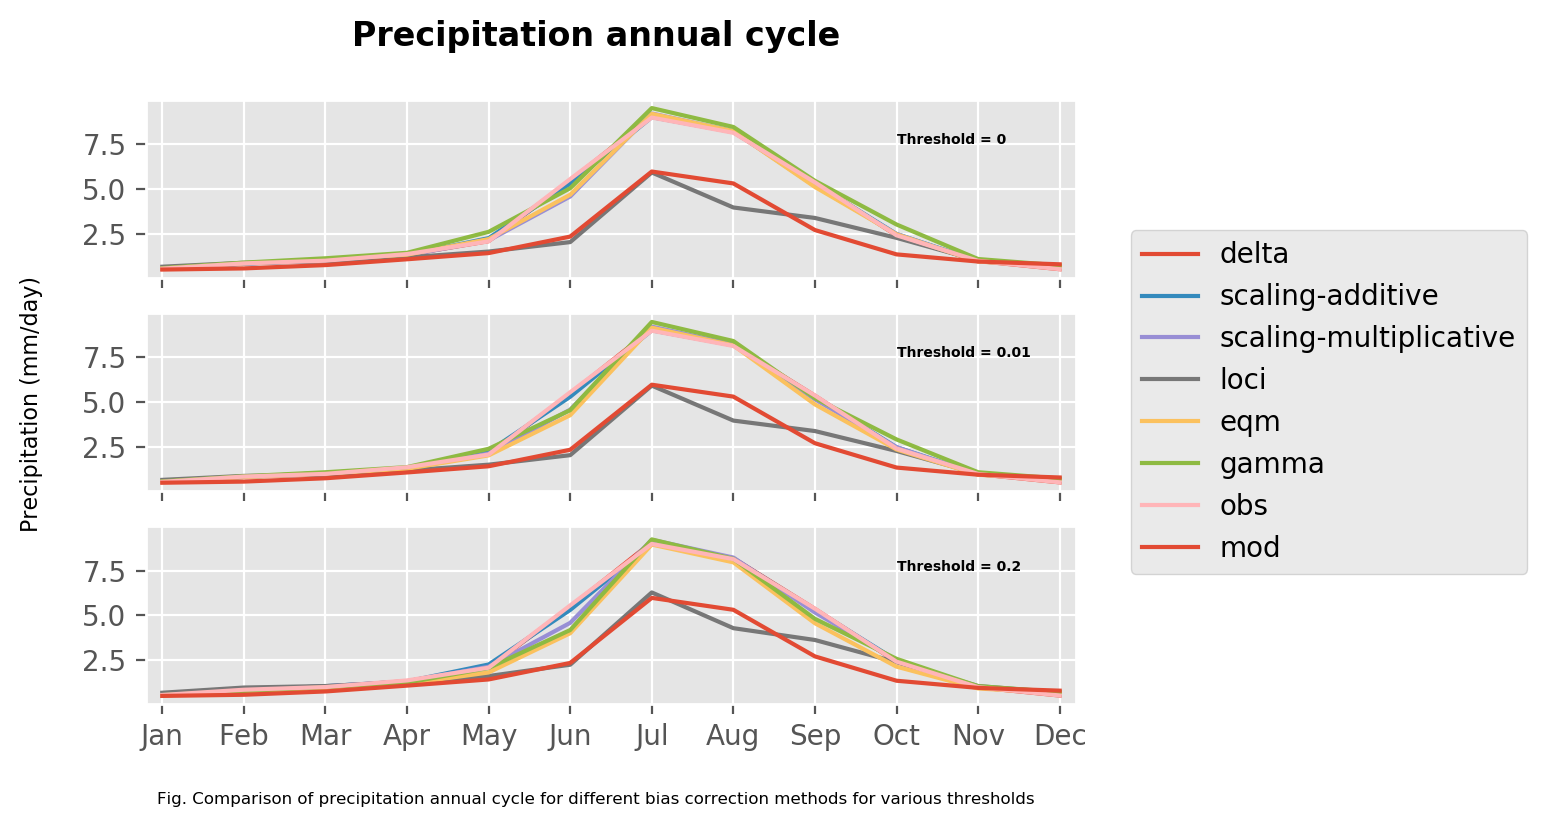

In [9]:
fig, axn = plt.subplots(3, 1, sharex=True, sharey=True, dpi=200)

(ax1, ax2, ax3) = axn

ax1.set_xlim(0.8, 12.2)
ax1.set_xticks(np.arange(1, 13))
ax1.set_yticks(np.arange(0, 12.5, 2.5))

i = 0
for thresh in precip_monclim['mw30-15'].keys():
    select_dict = precip_monclim['mw30-15'][thresh]
    plotaxes = select_dict.plot(ax=axn[i], legend=False)    
    i += 1

ax1.set_yticklabels(np.arange(0, 12.5, 2.5))
addmonthtext = ax3.set_xticklabels(month_abbr[1:])

threshtext = iter([0, 0.01, 0.2])
for ax in axn:
    orig.plot(ax=ax, legend=False)
    ax.text(10, 7.5, f'Threshold = {next(threshtext)}', 
            fontweight='bold',
            size=5)

patches, labels = plotaxes.get_legend_handles_labels()
leg = ax2.legend(patches, labels, loc="center right",
           bbox_to_anchor=(1.5, 0.5))

caption = "Fig. Comparison of precipitation annual cycle "\
         +"for different bias correction methods for various thresholds"

# Hit and trial or positioning?
## TODO: get axes coordinates (in terms of figure coordinates), relative adjustment 
caption = fig.text(0.5, 0, caption, ha="center", size=6)

# Common ylabel
ylab = fig.text(0.02, 0.5, "Precipitation (mm/day)", 
                va="center", rotation="vertical", size=8)

suptitle = fig.suptitle("Precipitation annual cycle", fontweight="bold")

In [248]:
fig.savefig('../../output/plots/analysis1/precip/base_monlcim_thresh.pdf', 
            dpi=400, bbox_inches='tight',
            bbox_extra_artist=(leg,))

### Experimenting with combining multivariable xarray datasets

In [113]:
precip_new = get_directory_structure('/home/abhi/Documents/mygit/BC/output/precip/mw30-15/base/')['base']
precip_new = {'mw30-15': precip_new}
threshlist = [0, 0.01, 0.2]
os.chdir('/home/abhi/Documents/mygit/BC/output/precip/mw30-15/base/')

method = 'mw30-15'
for thresh in np.array(threshlist, dtype=str):
    select_dict = precip_new[method][thresh]
    for BCtype in select_dict.keys():
        target_file = f'{thresh}/{BCtype}'
        if not '360day' in target_file:
            select_dict[BCtype] = homo_dims(xr.open_dataset(target_file)).precip
os.chdir("/home/abhi/Documents/mygit/postBC_diagnostic/src/notebooks")

/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'precip' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'precip' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'precip' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'precip' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'precip' has mul

In [114]:
for method in ['mw30-15']:
    for thresh in ['0', '0.01', '0.2']:
        precip_new[method][thresh] = xr.Dataset(precip_new[method][thresh]).assign_attrs({'threshold': thresh})

In [115]:
with open("../../output/pickled_objects/analysis1/precip_new.pickle", "wb") as writeFile:
    cpickle.dump(precip_new, writeFile)

In [142]:
mf_xr = precip_new['mw30-15']['0.01'].filter_by_attrs(longname='precip')

In [120]:
def mapper(xr_ds):
    return xr_ds.groupby('time.month').mean(['time', 'lat', 'lon'])

In [121]:
%%time
mf_xr_climmean = {k: mapper(v) for k, v in precip_new['mw30-15'].items()}

CPU times: user 1min 1s, sys: 15.3 s, total: 1min 16s
Wall time: 2min 32s


In [16]:
mf_xr_climmeandf = {k : v.to_dataframe()
                    .assign(thresh=np.full(12, np.float(k)))
                    .assign(method=np.full(12, 'mw30-15')) 
                    for k, v in mf_xr_climmean.items()}

In [17]:
allthresh_climdf = pd.concat(objs=(mf_xr_climmeandf.values()), axis=0)
allthresh_climdf.sort_values(by=['thresh', 'month'], inplace=True)

## Bug in pandas, as inplace=True does not change the original df
allthresh_climdf = allthresh_climdf.reset_index().set_index(['method', 'thresh', 'month'])

In [19]:
with open("../../output/pickled_objects/analysis1/allthresh_climdf.pickle", "wb") as writeFile:
    cpickle.dump(allthresh_climdf, writeFile)

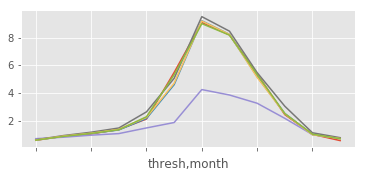

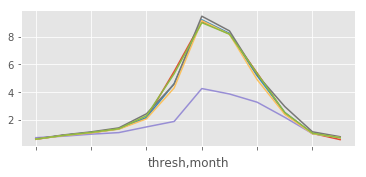

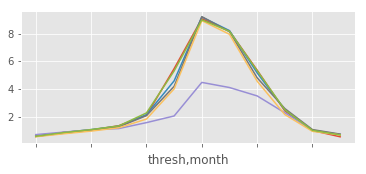

In [14]:
axn = allthresh_climdf.loc['mw30-15'].groupby('thresh').plot(legend=False, sharex=True, sharey=True)

for ax in axn:
    ax.set_aspect(0.5)

### Annual cycle comparison (Monthly boxplots)

In [15]:
sys.path.append("../scripts/")

In [16]:
from recipes import fldmean, getseas

In [17]:
from cftime import Datetime360Day

In [18]:
thresh = '0'

In [25]:
mf_xr = precip_new['mw30-15'][thresh]

In [26]:
%%time
df = fldmean(mf_xr).to_dataframe()
df.index = df.index.normalize()

CPU times: user 16.2 s, sys: 5.49 s, total: 21.7 s
Wall time: 39.7 s


In [27]:
obsdf = fldmean(obs).to_dataframe()
obsdf.index = obsdf.index.astype(str)
obsdf.index = pd.to_datetime(obsdf.index, errors='coerce')
obsdf = obsdf.loc[obsdf.index.to_series().dropna()]
obsdf.index = obsdf.index.normalize()
obsdf.rename({'precip': 'obs'}, axis=1, inplace=True)

In [28]:
moddf = fldmean(mod).to_dataframe()
moddf.index = moddf.index.astype(str)
moddf.index = pd.to_datetime(moddf.index, errors='coerce')
moddf = moddf.loc[moddf.index.to_series().dropna()]
moddf.index = moddf.index.normalize()
moddf.rename({'precip': 'raw'}, axis=1, inplace=True)

In [29]:
df_fldmean = pd.concat([df, obsdf, moddf], axis=1)

In [71]:
order = ['obs',
         'raw',
         'scaling-multiplicative',
         'loci',
         'eqm',
         'gamma']

names = order[:2] + ["scal-mul"] + order[3:]
colors = {'delta': '#E24A33',
          'scaling-multiplicative': '#348ABD',
          'loci': '#988ED5',
          'gamma': '#777777',
          'eqm': '#FBC15E',
          'scaling-additive': '#8EBA42',
          'raw': '#FFB5B8',
          'obs': 'white'}
             

In [31]:
df_fldmean = df_fldmean[order]

In [32]:
del df, obsdf, moddf

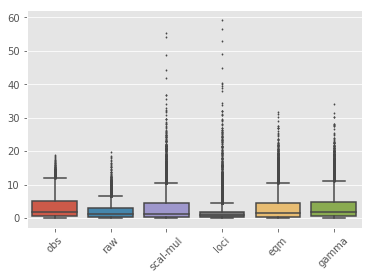

In [33]:
fig, ax = plt.subplots()
sns.boxplot(data=df_fldmean, ax=ax, fliersize=1)
xticklabels = ax.set_xticklabels(names, rotation=45)

In [34]:
df2 = df_fldmean.copy()

In [35]:
df2['month'] = df2.index.month

In [36]:
df2 = pd.melt(df2, id_vars='month')

In [37]:
df2['seas'] = df2.month.apply(getseas)

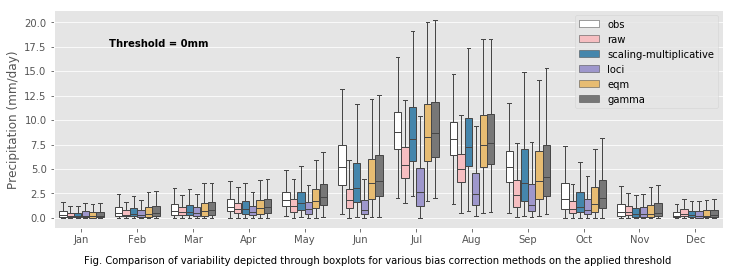

In [38]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.boxplot(x='month', y='value', hue='variable', data=df2, showfliers=False, ax=ax,
            linewidth=1,
            palette=['white']+[colors[key] for key in order[1:]])

ax.legend(loc='upper right')
leg = ax.get_legend()
leg.set_title('')

num_bc = len(order)
for i in range(0, 12*num_bc, num_bc):
    ax.artists[i].set_facecolor('white')

ax.set_xticklabels(month_abbr[1:])
ax.set_ylabel('Precipitation (mm/day)')
ax.set_xlabel('')

ax.text(0.5, 17.5, f'Threshold = {thresh}mm', fontweight='bold')

txt = fig.text(0.5, 0, 
         "Fig. Comparison of variability depicted through boxplots for various bias correction "+\
         "methods on the applied threshold", ha="center")

# fig.savefig(f"../../output/plots/analysis1/precip/{thresh}_precip_monboxplotcomp.png", dpi=400,
#             bbox_inches="tight")

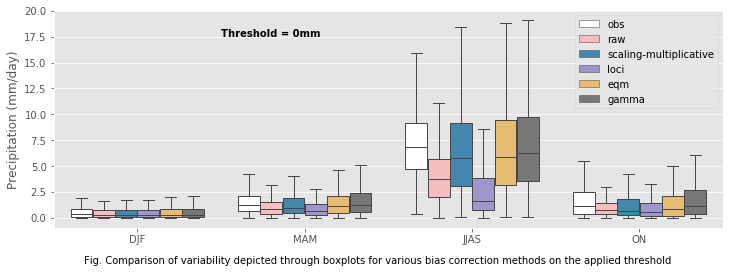

In [39]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.boxplot(x='seas', y='value', hue='variable', data=df2, showfliers=False, ax=ax,
            linewidth=1,
            palette=['white']+[colors[key] for key in order[1:]])
ax.legend(loc='upper right')
leg = ax.get_legend()
leg.set_title('')

num_bc = len(order)
for i in range(0, 4*num_bc, num_bc):
    ax.artists[i].set_facecolor('white')

ax.set_ylabel('Precipitation (mm/day)')
ax.set_xlabel('')

ax.text(0.5, 17.5, f'Threshold = {thresh}mm', fontweight='bold')

txt = fig.text(0.5, 0, 
         "Fig. Comparison of variability depicted through boxplots for various bias correction "+\
         "methods on the applied threshold", ha="center")

# fig.savefig(f"../../output/plots/analysis1/precip/{thresh}_precip_seasboxplotcomp.png", dpi=400,
#             bbox_inches="tight")

In [40]:
%time
stats.ks_2samp(df_fldmean['eqm'], df_fldmean['obs'])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.9 µs


Ks_2sampResult(statistic=0.05135839225902494, pvalue=8.871718571948357e-13)

#### ALL INDIA Mean monthly BIAS, RMSE

<font color="red">IMPORTANT!</font>:The **BIAS** and **RMSE** calculated here is for the ALL INDIA MEAN PRECIPITATION (i.e. after taking the fldmean of the spatial field). A different result will be obtained in case of **RMSE** if you calcuate it separately for each grid point and then take the mean.


###### BIAS

In [41]:
bias_df = df_fldmean.sub(df_fldmean['obs'], axis=0).groupby(df_fldmean.index.month).mean().drop('obs', axis=1)

In [42]:
bias_df.reset_index(inplace=True)
bias_df.rename({'time': 'month'}, inplace=True, axis=1)

In [43]:
bias_df = bias_df.melt(id_vars=['month'])

In [44]:
bias_df.head()

,month,variable,value
0,1,raw,-0.053419
1,2,raw,-0.261322
2,3,raw,-0.244792
3,4,raw,-0.289143
4,5,raw,-0.652763


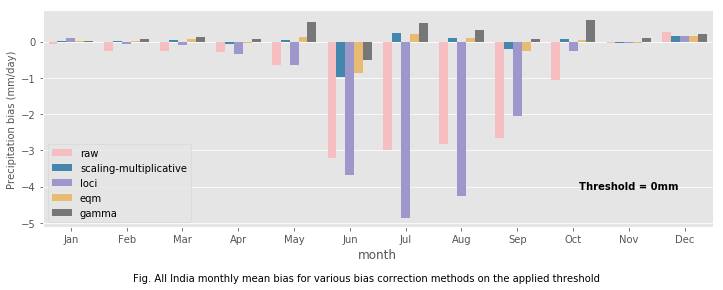

In [53]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(data=bias_df, 
            x='month', 
            y='value', 
            hue='variable', 
            ax=ax, 
            palette=[colors[name] for name in order if name != 'obs'])

ax.legend(loc='lower left')
leg = ax.get_legend()
leg.set_title('')

ax.set_xticklabels(month_abbr[1:])
ax.text(10, -4, f'Threshold = {thresh}mm', fontweight='bold', 
        ha='center', va='center')
ax.set_ylabel("Precipitation bias (mm/day)", size=10)

fig.text(0.5, -0.05, 
         "Fig. All India monthly mean bias for various bias correction methods on the applied threshold",
         ha="center", va="center")

fig.savefig(f"../../output/plots/analysis1/precip/{thresh}_precip_monmeanbias.png", dpi=400,
            bbox_inches="tight")

In [54]:
bias_df['seas'] = bias_df.month.apply(getseas)

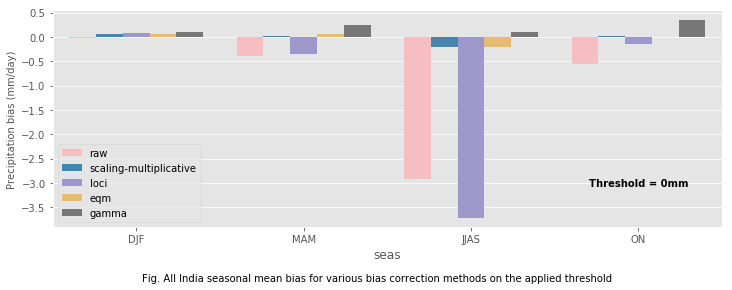

In [55]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(data=bias_df, 
            x='seas', 
            y='value', 
            hue='variable', 
            ax=ax, 
            palette=[colors[name] for name in order if name != 'obs'], ci=False)

ax.legend(loc='lower left')
leg = ax.get_legend()
leg.set_title('')

ax.text(3, -3, f'Threshold = {thresh}mm', fontweight='bold', ha='center', va='center')
ax.set_ylabel("Precipitation bias (mm/day)", size=10)


fig.text(0.5, -0.05, 
         "Fig. All India seasonal mean bias for various bias correction methods on the applied threshold",
         ha="center", va="center")

fig.savefig(f"../../output/plots/analysis1/precip/{thresh}_precip_seasmeanbias.pdf", dpi=400,
            bbox_inches="tight")

###### RMSE

In [56]:
df_fldmean_res = df_fldmean.resample('MS').mean()
rmse_df = (((df_fldmean_res.subtract(df_fldmean_res['obs'], axis=0)
               .drop('obs', axis=1)
               .abs())**2)
             .groupby(df_fldmean_res.index.month)).mean()
rmse_df.index.name = 'month'
rmse_df.reset_index(inplace=True)
rmse_df = rmse_df.melt(id_vars=['month'])
rmse_df['seas'] = rmse_df['month'].apply(getseas)

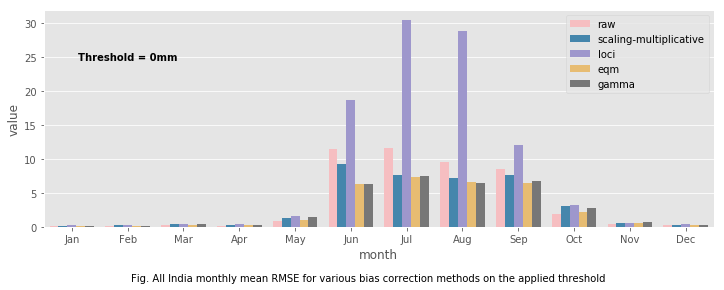

In [57]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(data=rmse_df, 
            x='month', 
            y='value', 
            hue='variable', 
            ax=ax, 
            palette=[colors[name] for name in order if name != 'obs'])

ax.legend(loc='upper right')
leg = ax.get_legend()
leg.set_title('')

xticklabels = ax.set_xticklabels(month_abbr[1:])

ax.text(1, 25, f'Threshold = {thresh}mm', fontweight='bold', ha='center', va='center')

fig.text(0.5, -0.05, 
         "Fig. All India monthly mean RMSE for various bias correction methods on the applied threshold",
         ha="center", va="center")

fig.savefig(f"../../output/plots/analysis1/precip/{thresh}_precip_monmeanrmse.pdf", dpi=400,
            bbox_inches="tight")

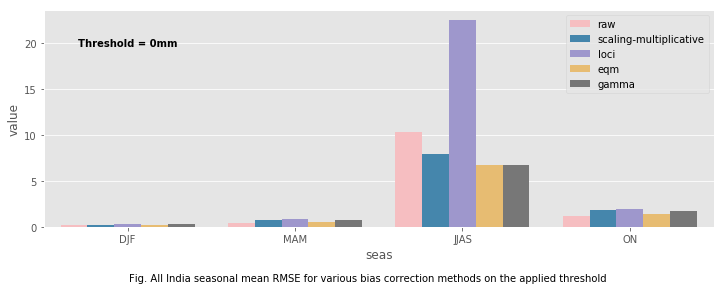

In [58]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(data=rmse_df, 
            x='seas', 
            y='value', 
            hue='variable', 
            ax=ax, 
            palette=[colors[name] for name in order if name != 'obs'], ci=False)

ax.legend(loc='upper right')
leg = ax.get_legend()
leg.set_title('')

ax.text(0, 20, f'Threshold = {thresh}mm', fontweight='bold', ha='center', va='center')

fig.text(0.5, -0.05, 
         "Fig. All India seasonal mean RMSE for various bias correction methods on the applied threshold",
         ha="center", va="center")

fig.savefig(f"../../output/plots/analysis1/precip/{thresh}_precip_seasmeanrmse.pdf", dpi=400,
            bbox_inches="tight")

In [224]:
ti = pd.Series(obs.indexes['time'])

In [232]:
ti = pd.to_datetime(cft.apply(lambda x: x.strftime("%Y-%m-%d")), errors='coerce')

In [230]:
obs2 = obs.copy()

In [236]:
cft = obs2['time']

In [237]:
cft.values = ti

In [254]:
obs2.indexes['time'].dropna()

DatetimeIndex(['1971-01-01', '1971-01-02', '1971-01-03', '1971-01-04',
               '1971-01-05', '1971-01-06', '1971-01-07', '1971-01-08',
               '1971-01-09', '1971-01-10',
               ...
               '2000-12-21', '2000-12-22', '2000-12-23', '2000-12-24',
               '2000-12-25', '2000-12-26', '2000-12-27', '2000-12-28',
               '2000-12-29', '2000-12-30'],
              dtype='datetime64[ns]', name='time', length=10748, freq=None)

In [275]:
obs2.where(~obs2.time.isnull(), drop=True)

<xarray.Dataset>
Dimensions:  (lat: 129, lon: 135, time: 10748)
Coordinates:
  * time     (time) datetime64[ns] 1971-01-01 1971-01-02 ... 2000-12-30
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
Data variables:
    precip   (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    CDI:          Climate Data Interface version 1.9.3 (http://mpimet.mpg.de/...
    Conventions:  CF-1.4
    history:      Fri Mar 23 16:35:10 2018: ncrename -d t,time imdCAL.nc\nFri...
    CDO:          Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/...
    NCO:          4.7.3

In [280]:
df_fldmean.corrwith(df_fldmean.obs)

obs                       1.000000
raw                       0.646530
delta                     0.999476
scaling-additive          0.770024
scaling-multiplicative    0.586173
loci                      0.291379
eqm                       0.637044
gamma                     0.642677
dtype: float64

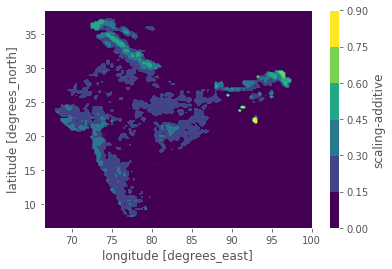

In [329]:
neg.mean(dim='time').plot.contourf()

### Rainfall distribution histograms

#### The IMD classification of rainfall

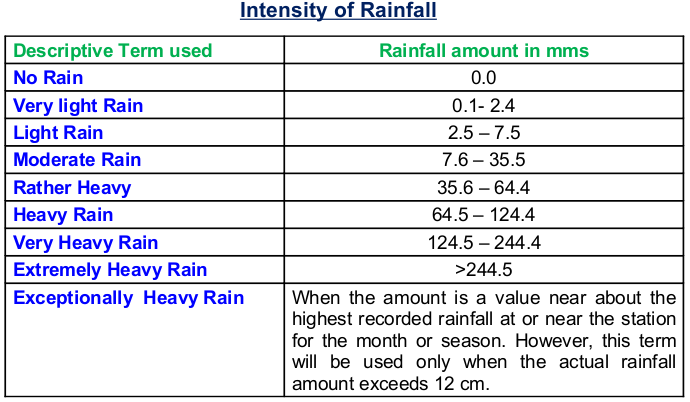

In [62]:
Image('../../sciref/analysis1/IMD_rainfall_class.png')

#### Histogram frequencies, for different months/whole time series for various thresholds

##### Define a function to generate normalized histogram frequencies

In [63]:
def xr_hist(xr_ds, var, bins, dimname='time'):
    '''
    Generate a histogram from an xarray dataset,
    xr_ds: xarray dataset
    var: variable name
    bins: bins
    plot: whether to plot the histogram or not
    '''
    val_arr = xr_ds[var].values
    val_arr = val_arr[~np.isnan(val_arr)]
    hist, bin_edges = np.histogram(val_arr, bins=bins)
    return hist/val_arr.size, bin_edges

##### Select the multivariable xarray dataset

In [64]:
thresh = '0'

In [65]:
mf_xr = precip_new['mw30-15'][thresh]

##### Select the bins

In [66]:
bins = np.array([0, 0.1, 2.4, 7.5, 35.5, 64.4, 124.4, 244.4, 10000])

##### Make a histogram dataframe containing the histogram frequencies for all variables for easy plotting 

In [68]:
seas = 'JJAS'

In [69]:
from recipes import selseas

In [70]:
%%time
hist_df = {}
hist_df['raw'] = xr_hist(selseas(mod, seas), 
                                 'precip', bins)[0]
hist_df['obs'] = xr_hist(selseas(obs, seas), 
                                 'precip', bins)[0]

for var in mf_xr.var().keys():
    hist_df[var] = xr_hist(selseas(mf_xr, seas), var, bins)[0]

hist_df = pd.DataFrame(hist_df).loc[:, order]


/home/abhi/miniconda3/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


CPU times: user 9.26 s, sys: 2.08 s, total: 11.3 s
Wall time: 11.4 s


In [146]:
# Checking if all frequencies add to 1
hist_df.sum()

obs                       1.0
raw                       1.0
scaling-multiplicative    1.0
loci                      1.0
eqm                       1.0
gamma                     1.0
dtype: float64

In [152]:
# Accross the different bins does the model over-simulate or under simulate the categories?
hist_df.sub(hist_df['obs'], axis=0).drop('obs', axis=1)

,raw,scaling-multiplicative,loci,eqm,gamma
0,0.012794,-0.037661,0.210941,0.006030,0.021216
1,0.048421,0.027257,-0.015432,0.000735,-0.061066
2,0.015225,0.008423,-0.055726,-0.000793,0.014066
3,-0.044605,0.011065,-0.108167,-0.004479,0.031666
4,-0.022075,-0.007316,-0.022611,-0.000979,-0.003979
5,-0.008359,-0.002421,-0.008101,-0.000275,-0.001752
6,-0.001330,0.000241,-0.001093,-0.000172,-0.000210
7,-0.000070,0.000412,0.000188,-0.000067,0.000059


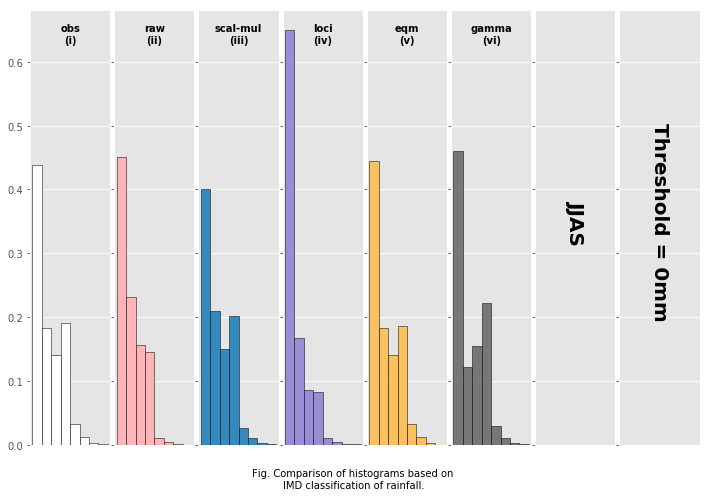

In [73]:
fig, axn = plt.subplots(1, 8, figsize=(12, 8),
                        sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.05)

i = 0
ronum = ['i', 'ii', 'iii', 'iv', 
         'v', 'vi', 'vii', 'viii']

ronum = list(map(lambda x: f'({x})', ronum))

color = (0.8862745098039215, 0.2901960784313726, 0.2, 1.0)
ordered_col = [colors[key] for key in order]
for col in hist_df.columns:
    hist_df[col].plot.bar(ax=axn[i], color=ordered_col[i], 
                          width=1, edgecolor='black')
    axn[i].set_xticks([])
    midx = np.mean(axn[i].get_xlim())
    axn[i].text(midx, 0.63, f'{names[i]}\n{ronum[i]}', ha="center", fontweight="bold")
    i += 1

axn[-2].text(midx, 0.35, seas, va="center", ha="center", rotation=270,
            size=20, fontweight="bold")
axn[-1].text(midx, 0.35, f'Threshold = {thresh}mm', va="center", ha="center", rotation=270,
            size=20, fontweight="bold")
txt = fig.text(0.5, 0.05,
               "Fig. Comparison of histograms based on \nIMD classification of rainfall.",
               ha="center")

In [74]:
fig.savefig(f"../../output/plots/analysis1/precip/{thresh}_precip_JJAS_histcompIMD_color.pdf", dpi=400)

### Goodness of fit tests 

#### Based on a single location time series (extraction of lat, lon)

##### Extract a single location

In [19]:
from recipes import selmon

In [20]:
point_data = selmon(mod.sel(lon=73, lat=18, method="nearest"), 8)
val_arr = point_data.precip.values.flatten()

##### Fit it to the distribution and compare with the histogram

KstestResult(statistic=0.0276862189850742, pvalue=0.4941310035818367) 

The data follows a gamma distribution


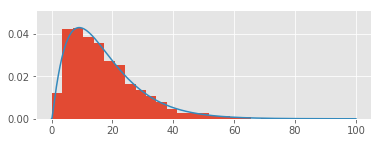

In [21]:
dist = getattr(stats, 'gamma')
a, b, c = dist.fit(val_arr)
fitted = dist.rvs(a, b, c, size=val_arr.size)
args = (a, b, c)

plt.figure(figsize=(6, 2))
res = plt.hist(val_arr, bins=np.linspace(0, 100, 30), density=True, )
x = np.linspace(0, 100, 1000)
pdf = dist.pdf(x, *args)

plt.plot(x, pdf)
ylim = plt.ylim(0, res[0].max()*1.2)
res = stats.kstest(val_arr, dist.name, args)
print(res, '\n')

alpha = 0.1
if res.pvalue < 0.1:
    print(f'The data does NOT follow a {dist.name} distribution',
          f'Tested at {(1-alpha)*100}% confidence level')
else:
    print(f'The data follows a {dist.name} distribution')
    


In [598]:
fitted_xr = xr.DataArray(fitted, dims={'time':point_data['time']})

In [600]:
fitted_xr = fitted_xr.assign_coords(time=point_data['time'])

#### Shapiro-Wilks test for normality

##### Example of fitting to a normal curve

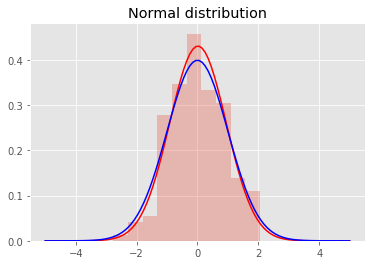

In [158]:
from scipy.stats import norm
from numpy import linspace
from pylab import plot,show,hist,figure,title

# picking 150 of from a normal distrubution
# with mean 0 and standard deviation 1
samp = norm.rvs(loc=0,scale=1,size=150) 

param = norm.fit(samp) # distribution fitting

# now, param[0] and param[1] are the mean and 
# the standard deviation of the fitted distribution
x = linspace(-5,5,100)
# fitted distribution
pdf_fitted = norm.pdf(x,loc=param[0],scale=param[1])
# original distribution
pdf = norm.pdf(x)

title('Normal distribution')
p = plot(x,pdf_fitted,'r-',x,pdf,'b-')
h = hist(samp,density=True,alpha=.3)

##### Comparison of pdf and cdf

<ol>
    <p>The following is carried out </p>
    <li>Comparing histogram with fitted curve</li>
    <li>Comparing the ECDF with normal CDF</li>
    <li>Comparing the quantiles with the theoritical quantiles (qqplot)</li>
        
        
</ol>

Shapiro-Wilk-test,
 W: 0.9991766214370728 
 p-value: 0.9476742744445801
KstestResult(statistic=0.018907669230359192, pvalue=0.8670340905556801)
Calculated D statistic 0.01790766923035919


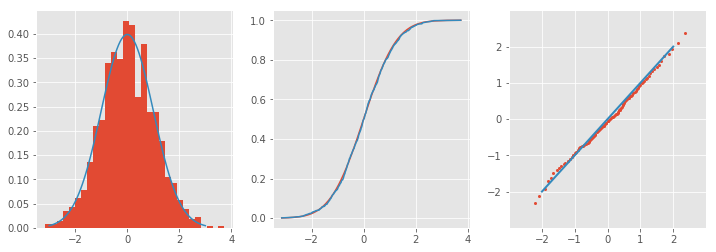

In [159]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

sample = stats.norm.rvs(size=1000)
W, p = stats.shapiro(sample)
res = ax1.hist(sample, bins=30, density=True)

x = np.linspace(-3, 3, 100)
ecdf = ECDF(sample)
pdf = stats.norm.pdf(x)
cdf = stats.norm.cdf(ecdf.x)

ax1.plot(x, pdf)

print(f'Shapiro-Wilk-test,\n W: {W}','\n',
      f'p-value:', p)

alpha = 0.1
if p < alpha:
    print("The sample is not normal with a 90% confidence")
    
print(stats.kstest(sample, 'norm'))

ax2.plot(ecdf.x, cdf)
ax2.plot(ecdf.x, ecdf.y)

print(f"Calculated D statistic {(np.abs(ecdf.y - cdf)).max()}")

sampleq = np.percentile(sample, np.linspace(0, 100, 100))
normalq = np.percentile(stats.norm.rvs(size=sample.size, loc=sample.mean(), scale=sample.std()),
                        np.linspace(0, 100, 100))

ax3.plot(normalq, sampleq, 'o', markersize=2)
ax3.set_xlim(-3, 3)
ax3.set_ylim(-3, 3)
xticks = ax3.set_xticks(range(-2, 3, 1))
yticks = ax3.set_yticks(range(-2, 3, 1))
ax3.plot(np.linspace(-2, 2, 100),  np.linspace(-2, 2, 100), '-', linewidth=2)


### Comparing Distributions of Raw v/s Observation

In [23]:
month = 8
lon, lat = 73, 18


In [63]:
mf_xr = precip_new['mw30-15']['0']

In [65]:
mf_xr.eqm

<xarray.DataArray 'eqm' (time: 10748, lat: 129, lon: 135)>
[187176420 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * time     (time) datetime64[ns] 1971-01-01T12:00:00 ... 2000-12-30T12:00:00
Attributes:
    description:  GRIDDED RAINFALL
    longname:     precip

In [66]:
raw_point = selmon(mod.sel(lon=lon, lat=lat, method="nearest"), month).precip.values.flatten()
eqm_point = selmon(mf_xr.eqm.sel(lon=lon, lat=lat, method="nearest"), month).values.flatten()
obs_point = selmon(obs.sel(lon=lon, lat=lat, method="nearest"), month).precip.values.flatten()

In [89]:
raw_ecdf = ECDF(raw_point)
obs_ecdf = ECDF(obs_point)
eqm_ecdf = ECDF(eqm_point)

In [27]:
from scipy.stats import gaussian_kde, norm
def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

In [43]:
%time
x_grid = np.linspace(0, 300, 1000)
raw_kernel = kde_scipy(raw_point, x_grid, bandwidth=2)
obs_kernel = kde_scipy(obs_point, x_grid, bandwidth=2)
print("Done!")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.3 µs
Done!


In [67]:
raw_q = np.percentile(raw_point, np.linspace(0, 100, 100))
obs_q = np.percentile(obs_point, np.linspace(0, 100, 100))
eqm_q = np.percentile(eqm_point, np.linspace(0, 100, 100))

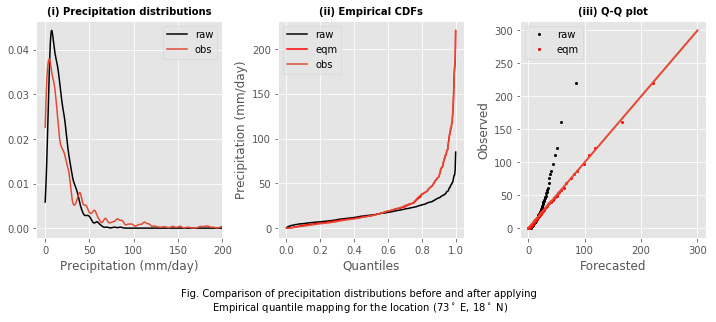

In [120]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, 
                                    figsize=(12, 4))

fig.subplots_adjust(wspace=0.3)
ax1.plot(x_grid, raw_kernel, color='black', label='raw')
ax1.plot(x_grid, obs_kernel, label='obs')
ax1.legend()
ax1.set_xlim(-10, 200)
ax1.set_xlabel('Precipitation (mm/day)')
ax1.set_title('(i) Precipitation distributions', size=10, fontweight='bold')

ax2.plot(raw_ecdf.y, raw_ecdf.x, color='black', label='raw')
ax2.plot(eqm_ecdf.y, eqm_ecdf.x, color='red', label='eqm')
ax2.plot(obs_ecdf.y, obs_ecdf.x, label='obs')
ax2.set_ylabel('Precipitation (mm/day)')
ax2.set_title('(ii) Empirical CDFs', size=10, fontweight='bold')
ax2.set_xlabel("Quantiles")
ax2.legend()

ax3.plot(raw_q, obs_q, 'o', markersize=2, color='black', label='raw')
ax3.plot(eqm_q, obs_q, 'o', markersize=2, color='red', label='eqm')
ax3.plot(np.linspace(0, 300, 100),  
         np.linspace(0,300, 100), '-', linewidth=2)
ax3.legend()

ax3.set_ylabel("Observed")
ax3.set_xlabel("Forecasted")
ax3.set_title('(iii) Q-Q plot', size=10, fontweight='bold')

caption = fig.text(0.5, -0.1,
                    "Fig. Comparison of precipitation distributions before and after applying \n"+\
                    "Empirical quantile mapping for the location (73$^\circ$ E, 18$^\circ$ N)",
                     ha="center",
                     va="center")

fig.savefig("../../output/plots/analysis1/precip/0_eqmdistributioncomp7318", dpi=400,\
            bbox_inches="tight")

In [69]:
eqm_q.size

100

In [53]:
obs_ecdf.x

array([          -inf, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.14390835e-01, 1.90651372e-01,
       1.90651372e-01, 1.96740925e-01, 2.85977066e-01, 2.85977066e-01,
       3.38327914e-01, 3.81302744e-01, 4.50904995e-01, 4.72722948e-01,
       4.76628453e-01, 5.13299167e-01, 5.46230674e-01, 5.86778283e-01,
       5.95646322e-01, 6.29149497e-01, 6.29163623e-01, 6.41556382e-01,
       6.44420683e-01, 6.58556342e-01, 7.12370276e-01, 7.14352667e-01,
       8.18492234e-01, 8.32207739e-01, 8.37276042e-01, 8.37276042e-01,
       8.85041356e-01, 9.30397749e-01, 9.63854671e-01, 9.88950074e-01,
       1.10676086e+00, 1.11716592e+00, 1.14390826e+00, 1.16694081e+00,
      

### Seasonal precipitation bias

#### PRECIS seasonal precipitation patterns (Historical simulation 1971-2000)

/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


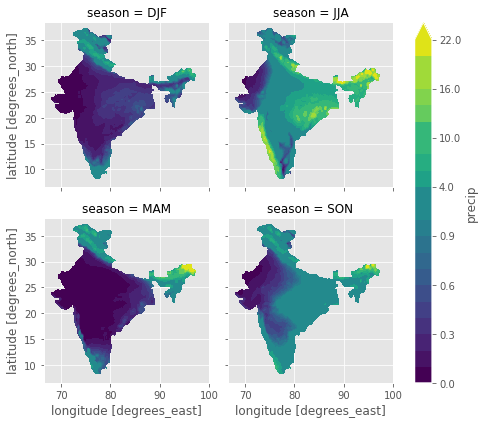

In [160]:
t_season_mod = mod.precip.groupby('time.season').mean('time')
cont_levels = np.around(np.concatenate([np.arange(0, 1.1, 0.1), 
                                        np.arange(2, 24, 2)]),
                        decimals=1)
t_season_mod.plot.contourf(x='lon', y='lat', col='season', 
                       col_wrap=2, levels=cont_levels)                      

#### IMD Observation seasonal precipitation patterns 1971-2000

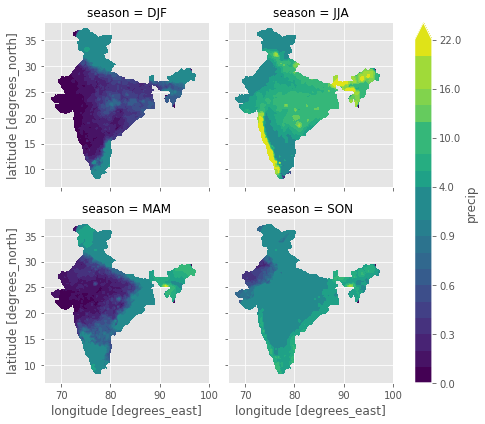

In [161]:
t_season_obs = obs.precip.groupby('time.season').mean('time')
cont_levels = np.around(np.concatenate([np.arange(0, 1.1, 0.1), 
                                        np.arange(2, 24, 2)]),
                        decimals=1)
t_season_obs.plot.contourf(x='lon', y='lat', col='season', 
                       col_wrap=2, levels=cont_levels)   

#### Seasonal precipitation mean BIAS

In [162]:
t_bias = t_season_mod - t_season_obs

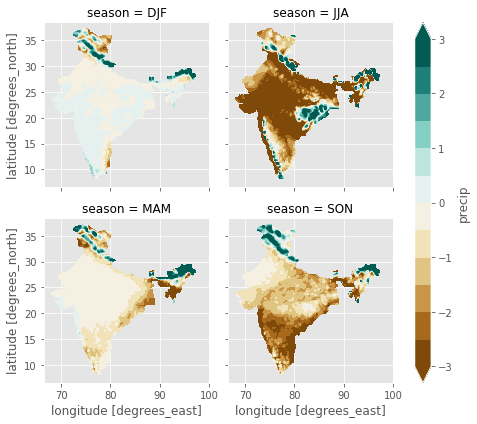

In [163]:
t_bias.plot.contourf(x='lon', y='lat', col='season', 
                       col_wrap=2, levels=np.arange(-3, 3.5, 0.5), cmap='BrBG') 

##### Calculate the seasonal mean and concat along the seas dimension (created)
Is there a better way to do this?

In [164]:
seasmean_dict = OrderedDict()

for seas in ['DJF', 'MAM', 'JJAS', 'ON']:
    seasmean_dict[seas] = selseas(mod, seas).mean('time')

In [165]:
seasmean_concat = xr.concat(seasmean_dict.values(), dim=pd.Index(['DJF', 'MAM', 'JJAS', 'ON'], name='seas'))

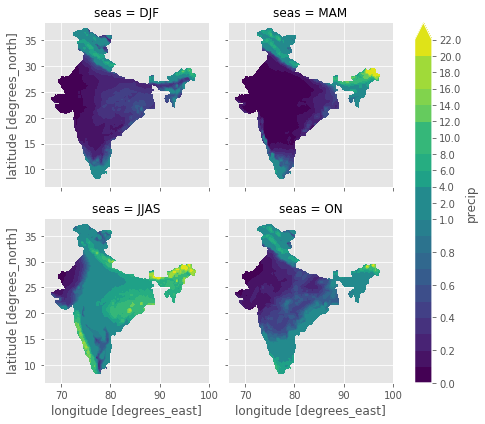

In [166]:
cont_levels = np.around(np.concatenate([np.arange(0, 1.1, 0.1), 
                                        np.arange(2, 24, 2)]), decimals=1)
                        
conplot = seasmean_concat.precip.plot.contourf(x='lon', y='lat', col='seas',
                                               col_wrap=2, levels=cont_levels)

cbar_ticks = np.around(np.concatenate([np.arange(0, 1.2, 0.2), np.arange(2, 24, 2)]), decimals=1)
conplot.cbar.set_ticks(cbar_ticks)

In [167]:
def plot_seasmean(xr_ds,
                  cont_levels = np.around(np.concatenate([np.arange(0, 1.2, 0.2),
                                                          np.arange(2, 24, 2)]), 
                                          decimals=1),
                  cmap='viridis'):
                  
                  
    seasons = ['DJF', 'MAM', 'JJAS', 'ON']
    concat_ds = xr.concat([selseas(xr_ds, seas).mean('time') for seas in seasons], 
                          dim=pd.Index(seasons, name='seas'))

    
    var_name = list(concat_ds.var())[0]
                        
    plot = concat_ds[var_name].plot.contourf(x='lon', y='lat', col='seas',
                                               col_wrap=2, levels=cont_levels,
                                            cmap=cmap)
    
    cbar_ticks = cont_levels[::2]
    
    plot.cbar.set_ticks(cbar_ticks)
    
    i = 0
    for ax_col in plot.axes:
        for ax in ax_col:
            ax.set_title(seasons[i])
            ax.set_xlabel('')
            ax.set_ylabel('')
            
            i += 1
    
    return plot

In [168]:
os.chdir("/home/abhi/Documents/mygit/postBC_diagnostic/src/notebooks")

/home/abhi/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  del sys.path[0]
/home/abhi/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: calling len() on an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Call len() on the Dataset.variables property instead, like ``len(ds.variables)``, to preserve existing behavior in a forwards compatible manner.
  del sys.path[0]


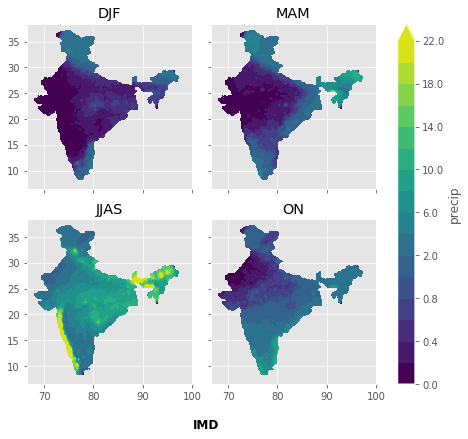

In [169]:
plot = plot_seasmean(obs)
plot.fig.text(0.45, 0, 'IMD', ha='center', size=12, fontweight='bold')
plot.fig.savefig("../../output/plots/analysis1/precip/IMD_seasmean_precip.pdf", 
                 dpi=400,
                 bbox_inches="tight")
                 

##### Plot seasonal bias

/home/abhi/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  del sys.path[0]
/home/abhi/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: calling len() on an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Call len() on the Dataset.variables property instead, like ``len(ds.variables)``, to preserve existing behavior in a forwards compatible manner.
  del sys.path[0]


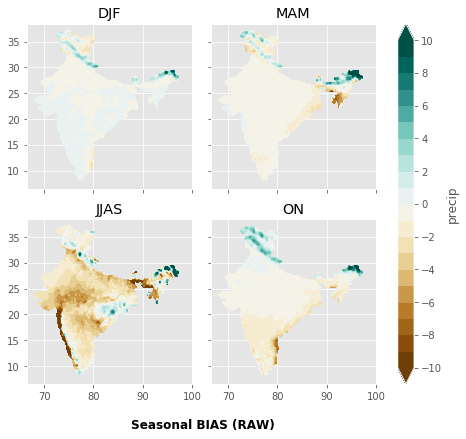

In [170]:
plot = plot_seasmean(mod-obs.precip.values, 
                     cont_levels=np.arange(-10, 11, 1), 
                     cmap='BrBG')

plot.fig.text(0.3, 0, 'Seasonal BIAS (RAW)', fontweight='bold', size=12)
plot.fig.savefig("../../output/plots/analysis1/precip/RAW_precip_seas_bias.pdf", dpi=400,
                 bbox_inches="tight")

### Various comparison metrics

In [109]:
fldmean_allbc = mf_xr.mean(['time', 'lat', 'lon'])

In [110]:
val = fldmean_allbc.to_array().values
varname = list(fldmean_allbc.keys())

/home/abhi/miniconda3/lib/python3.6/_collections_abc.py:702: FutureWarning: calling len() on an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Call len() on the Dataset.variables property instead, like ``len(ds.variables)``, to preserve existing behavior in a forwards compatible manner.
  return len(self._mapping)


In [111]:
from recipes import fldmean, ydaymean

In [112]:
m = ydaymean(fldmean(mod)).rename({'precip':'raw', 'time': 'dayofyear'}).to_dataframe()
o = ydaymean(fldmean(obs)).rename({'precip':'obs', 'time': 'dayofyear'}).to_dataframe()

In [113]:
dayofmon = []
dayspermon = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

i = 0
for mon in range(1, 13):
    dayofmon += range(1, dayspermon[i]+1)
    i += 1
dayofmon = np.array(dayofmon)

In [114]:
thresh = '0'

In [115]:
mf_xr = precip_new['mw30-15'][thresh]

In [116]:
fyday = ydaymean(fldmean(mf_xr))
fyday = fyday.to_dataframe()

fyday = fyday.reindex(np.arange(1, 366))

fyday.interpolate(method="linear", inplace=True)

dummy = pd.date_range('1999-01-01', '1999-12-31')

fyday['month'] = dummy.month

fyday.set_index(dayofmon, inplace=True)

fyday.drop(31, inplace=True)

fyday.index.name = 'dayofmonth'

fyday = fyday.reset_index()

fyday.loc[358] = fyday.loc[57, :].copy()
fyday.loc[359] = fyday.loc[57, :].copy()


fyday.index = range(1, 361)

fyday.drop(['dayofmonth', 'month'], axis=1, inplace=True)
fyday.index.name = 'dayofyear'

In [117]:
fyday['raw'] = m
fyday['obs'] = o

In [118]:
from matplotlib import cm

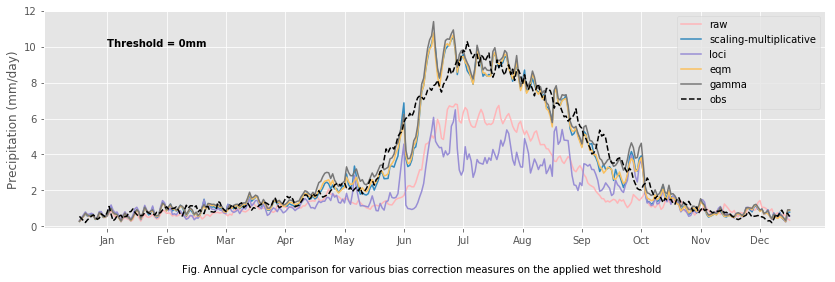

In [137]:
fig, ax = plt.subplots(figsize=(14, 4))
fyday.drop(['obs', 'scaling-additive', 'delta'], axis=1)[order[1:]].plot(ax=ax, legend=False,
                                                             color=[colors[name] for name in order if name != 'obs'])

fyday['obs'].plot(ax=ax, color='black', linestyle='--', legend=False)

ax.set_xlabel('')
ax.set_xticks(np.arange(15, 15+30*(12), 30))
mon_labels = ax.set_xticklabels(month_abbr[1:])

ftick = ax.get_xticks()[0]
ax.text(ftick, 10, f"Threshold = {mf_xr.threshold}mm", fontweight='bold')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, )

# colors = {labels[i]: handle.get_color() for i, handle in enumerate(handles)}

ax.set_ylim(-0.1, 12)
ax.set_ylabel('Precipitation (mm/day)')

txt = fig.text(0.5, -0.03, 
         'Fig. Annual cycle comparison for various bias '+\
         'correction measures on the applied wet threshold',
         ha='center')

fig.savefig(f"../../output/plots/analysis1/precip/{thresh}_annualcycle.pdf", dpi=400,
            bbox_inches="tight", bbox_extra_artists=(txt,))

### Rough playground because the scratchpad isn't enough!!

#### Selecting specific months

In [28]:
def selmon(xr_ds, months):
    return xr_ds.sel(time=np.isin(xr_ds['time.month'], months))

#### Monthly means

In [29]:
def monmean(xr_ds):
    return xr_ds.groupby('time.month').mean('time')

#### Select specific years

In [30]:
def selyear(xr_ds, years=None):
    if years is not None:
        return xr_ds.sel(time=np.isin(xr_ds['time.year'], years))

#### Yearly means

In [31]:
def yearmon(xr_ds):
    return xr_ds.groupby('time.year').mean('time')

#### Selecting specific seasons

In [32]:
def selseas(xr_ds, seas=None):
    if seas is 'DJF':
        return selmon(xr_ds, [12, 1, 2])
    elif seas is 'MAM':
        return selmon(xr_ds, [3, 4, 5])
    elif seas is 'JJAS':
        return selmon(xr_ds, [6, 7, 8, 9])
    elif seas is 'ON':
        return selmon(xr_ds, [10, 11])

#### Seasonal mean (India specific seasons)

In [33]:
def plot_seasmean(xr_ds):
    seasons = ['DJF', 'MAM', 'JJAS', 'ON']
    concat_ds = xr.concat([selseas(xr_ds, seas).mean('time') for seas in seasons], 
                          dim=pd.Index(seasons, name='seas'))
    cont_levels = np.around(np.concatenate([np.arange(0, 1.1, 0.1), 
                                        np.arange(2, 24, 2)]), decimals=1)
    
    var_name = list(concat_ds.var())[0]
                        
    plot = concat_ds[var_name].plot.contourf(x='lon', y='lat', col='seas',
                                               col_wrap=2, levels=cont_levels)
    
    cbar_ticks = np.around(np.concatenate([np.arange(0, 1.2, 0.2), 
                                           np.arange(2, 24, 2)]), decimals=1)
    
    plot.cbar.set_ticks(cbar_ticks)
    
    i = 0
    for ax_col in plot.axes:
        for ax in ax_col:
            ax.set_title(seasons[i])
            ax.set_xlabel('')
            ax.set_ylabel('')
            
            i += 1
    
    return plot

#### Select by lonlat box

In [34]:
def sellonlatbox(xr_ds, llbox):
    lon1, lon2, lat1, lat2 = llbox
    return xr_ds.sel(lon=(xr_ds.lon > lon1) & (xr_ds.lon < lon2),
                   lat=(xr_ds.lat > lat1) & (xr_ds.lat < lat2))


##### Plotting multi-variable xarray datasets

In [182]:
def plot_by_var(mv_xr, col_wrap, levels, cmap='BrBG'):
    var_names = list(mv_xr.var().keys())
    var_da = [mv_xr.rename({var:'precip'}).precip for var in var_names]
    concat_ds = xr.concat(var_da, pd.Index(var_names, name='vartype'))
    
    plot = concat_ds.plot.contourf(x='lon', y='lat', col='vartype',
                                   col_wrap=col_wrap, 
                                   levels=levels,
                                   cmap=cmap)
    i = 0
    for ax_col in plot.axes:
        try:
            for ax in ax_col:
                ax.set_title(var_names[i])
                ax.set_xlabel('')
                ax.set_ylabel('')

                i += 1
        except IndexError:
            continue
    
    return plot

In [183]:
for method in order:
    try:
        mf_xr = mf_xr.drop(method+'_360day')
    except ValueError:
        continue

for method in ['delta', 'scaling-multiplicative']:
    try:
        mf_xr = mf_xr.drop(method)
        mf_xr = mf_xr.drop(method+'_360day')
    except Exception:
        continue


In [184]:
from recipes import timmean, selseas

In [185]:
annual_bias = (timmean(mf_xr).assign(raw=timmean(mod).precip) - timmean(obs).precip)

/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


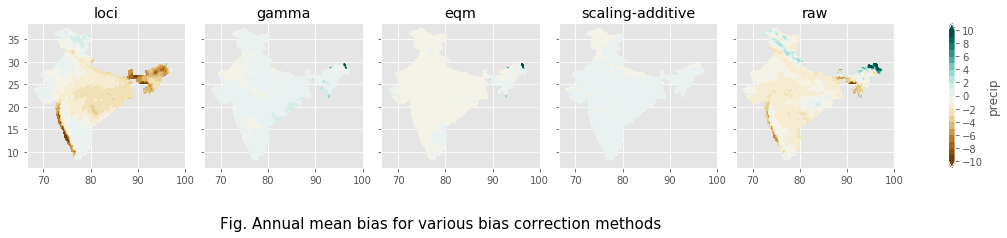

In [215]:
levels = np.arange(-10, 11, 1)
plot = plot_by_var(annual_bias, col_wrap=5, levels=levels)
plot.cbar.set_ticks(levels[::2])
plot.fig.text(0.4, -0.05, 
              'Fig. Annual mean bias for various bias correction methods',
              fontsize=15,
              ha='center', va='center')

plot.fig.savefig('../../output/plots/analysis1/precip/0_precip_annualbias.pdf', dpi=400,
            bbox_inches='tight')

In [195]:
seas_bias = (timmean(selseas(mf_xr, 'JJAS'))
               .assign(raw=timmean(selseas(mod, 'JJAS')).precip) 
               - timmean(selseas(obs, 'JJAS')).precip)

/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


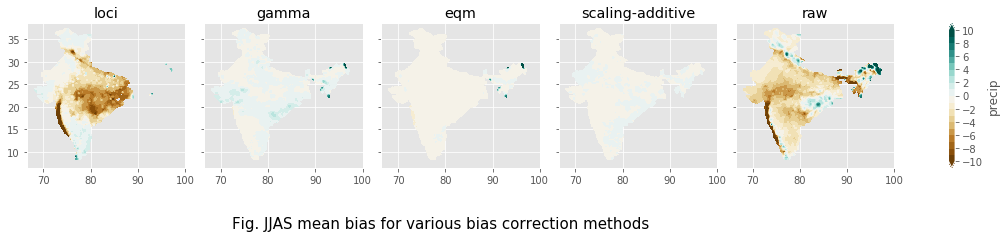

In [216]:
levels = np.arange(-10, 11, 1)
plot = plot_by_var(seas_bias, col_wrap=5, levels=levels)
plot.cbar.set_ticks(levels[::2])
plot.fig.text(0.4, -0.05, 
              'Fig. JJAS mean bias for various bias correction methods',
              fontsize=15,
              ha='center', va='center')

plot.fig.savefig('../../output/plots/analysis1/precip/0_precip_jjasbias.pdf', dpi=400,
            bbox_inches='tight')

In [218]:
df_fldmean_res.corrwith(df_fldmean_res['obs'])

obs                       1.000000
raw                       0.888953
scaling-multiplicative    0.842478
loci                      0.551138
eqm                       0.863285
gamma                     0.864935
dtype: float64

In [289]:
df_fldmean_bias = df_fldmean_res.sub(df_fldmean_res['obs'], axis=0).drop('obs', axis=1)

In [290]:
df_fldmean_bias['month'] = df_fldmean_bias.index.month
df_fldmean_bias['seas'] = df_fldmean_bias['month'].apply(getseas)

In [291]:
seasbias = df_fldmean_bias.groupby('seas').mean().drop('month', axis=1)

In [292]:
seasbias = seasbias.loc[['DJF', 'MAM', 'JJAS', 'ON'], :]

In [293]:
seasbias['metric'] = np.full(4, 'BIAS')

In [294]:
seasrmse = (((df_fldmean_bias
             .drop(['month', 'seas'], axis=1))**2)
            .groupby(df_fldmean_bias['seas']).mean()**(1/2))

In [374]:
seasrmse['metric'] = np.full(4, 'RMSE')
seasrmse = seasrmse.loc[['DJF', 'MAM', 'JJAS', 'ON'], :]

In [375]:
seasmae = df_fldmean_bias.groupby('seas').mean().drop('month', axis=1)

,raw,scaling-multiplicative,loci,eqm,gamma,metric
seas,,,,,,
DJF,-0.014550,0.059445,0.070263,0.058073,0.100042,BIAS
MAM,-0.395566,0.010149,-0.348487,0.053017,0.244864,BIAS
JJAS,-2.918039,-0.215998,-3.708652,-0.207323,0.106009,BIAS
ON,-0.551031,0.020207,-0.141965,0.006175,0.350011,BIAS


In [ ]:
def getabs(x):
    try:
        return x.abs()
    except Exception:
        return x

In [448]:
seasmae = (df_fldmean_bias.apply(getabs)
           .groupby('seas')
           .mean()
           .drop('month', axis=1)
           .assign(metric=np.full(4, 'MAE'))).loc[['DJF', 'MAM', 'JJAS', 'ON'], :]

In [449]:
seasmae


,raw,scaling-multiplicative,loci,eqm,gamma,metric
seas,,,,,,
DJF,0.389988,0.421976,0.454897,0.416067,0.427850,MAE
MAM,0.563361,0.614444,0.721987,0.577533,0.619122,MAE
JJAS,2.947554,2.169513,4.333207,2.031376,2.002516,MAE
ON,0.855590,0.988095,1.041547,0.900972,0.967596,MAE


In [376]:
seasrmse

,raw,scaling-multiplicative,loci,eqm,gamma,metric
seas,,,,,,
DJF,0.519381,0.558893,0.603994,0.548937,0.564558,RMSE
MAM,0.715368,0.868160,0.932790,0.780914,0.872094,RMSE
JJAS,3.214075,2.828094,4.743744,2.596302,2.611390,RMSE
ON,1.118385,1.372606,1.415226,1.226079,1.343733,RMSE


In [377]:
pd.concat([seasbias, seasrmse]).reset_index().set_index(['metric', 'seas'])

raw  scaling-multiplicative      loci       eqm     gamma
metric seas                                                                
BIAS   DJF  -0.014550                0.059445  0.070263  0.058073  0.100042
       MAM  -0.395566                0.010149 -0.348487  0.053017  0.244864
       JJAS -2.918039               -0.215998 -3.708652 -0.207323  0.106009
       ON   -0.551031                0.020207 -0.141965  0.006175  0.350011
RMSE   DJF   0.519381                0.558893  0.603994  0.548937  0.564558
       MAM   0.715368                0.868160  0.932790  0.780914  0.872094
       JJAS  3.214075                2.828094  4.743744  2.596302  2.611390
       ON    1.118385                1.372606  1.415226  1.226079  1.343733

In [389]:
seascorr = seasgrpd.corr()

In [390]:
seascorr.index.names = ['seas', 'var']

In [391]:
seascorr.reset_index(inplace=True)

In [392]:
seascorr = (seascorr[(seascorr['var']=='obs')]\
             .drop('var', axis=1)
             .assign(metric=np.full(4, 'CORR'))
             .set_index('seas')).loc[['DJF', 'MAM', 'JJAS', 'ON'], :].drop('obs', axis=1)

In [393]:
seascorr

,raw,scaling-multiplicative,loci,eqm,gamma,metric
seas,,,,,,
DJF,-0.172156,-0.027759,-0.104869,-0.008332,-0.014391,CORR
MAM,0.391117,0.337451,0.169053,0.417493,0.477064,CORR
JJAS,0.733615,0.502776,0.196892,0.539814,0.530238,CORR
ON,0.326984,0.454873,0.380037,0.483707,0.528746,CORR


In [450]:
metric_df = pd.concat([seasbias, seasmae, seasrmse, seascorr]).reset_index().set_index(['metric', 'seas'])

In [451]:
metric_df

raw  scaling-multiplicative      loci       eqm     gamma
metric seas                                                                
BIAS   DJF  -0.014550                0.059445  0.070263  0.058073  0.100042
       MAM  -0.395566                0.010149 -0.348487  0.053017  0.244864
       JJAS -2.918039               -0.215998 -3.708652 -0.207323  0.106009
       ON   -0.551031                0.020207 -0.141965  0.006175  0.350011
MAE    DJF   0.389988                0.421976  0.454897  0.416067  0.427850
       MAM   0.563361                0.614444  0.721987  0.577533  0.619122
       JJAS  2.947554                2.169513  4.333207  2.031376  2.002516
       ON    0.855590                0.988095  1.041547  0.900972  0.967596
RMSE   DJF   0.519381                0.558893  0.603994  0.548937  0.564558
       MAM   0.715368                0.868160  0.932790  0.780914  0.872094
       JJAS  3.214075                2.828094  4.743744  2.596302  2.611390
       ON    1.118385                1.372606  1.415226  1.226079  1.343733
CORR   DJF  -0.172156               -0.027759 -0.104869 -0.008332 -0.014391
       MAM   0.391117                0.337451  0.169053  0.417493  0.477064
       JJAS  0.733615                0.502776  0.196892  0.539814  0.530238
       ON    0.326984                0.454873  0.380037  0.483707  0.528746

In [5]:
metric_df21.style.background_gradient(cmap='RdBu', axis=0, low=0, high=0)

In [452]:
metric_df.to_csv("../../output/metric_df.csv")